In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans

from collections import Counter
import re

from sklearn.cluster import DBSCAN

pd.options.mode.chained_assignment = None 

In [2]:
df = pd.read_csv('Tag_pre.csv')
df

,Tags,Author Username,Times Viewed,Rating,Date,Time,Category
0,celebr parti board young famili sumer outdor h...,kato84,18570,46.8,2017-07-02,14:42,7
1,cute portrait beauti lok young beauti love ang...,photalina,124168,49.8,2014-05-14,18:36,7
2,swet flower cute ador life portrait beauti you...,sutiponmm,84304,48.9,2015-08-13,10:27,0
3,celebr drink parti board young famili sumer ou...,kato84,16932,46.1,2017-07-02,14:44,7
4,close - up portrait love two monochrom beard s...,Rainman,105510,49.9,2014-11-01,22:03,7
...,...,...,...,...,...,...,...
16298,top portrait beauti beauti canon light emot da...,FabioZenoardo,89,21.3,2015-04-02,14:48,7
16299,portrait beauti beauti bodi gorgeous model peo...,stateofart,522,36.0,2015-03-10,14:01,7
16300,autumn portrait beauti beauti light emot color...,getPictures,155,22.0,2015-03-16,18:21,7
16301,autumn portrait beauti beauti light emot color...,getPictures,185,27.8,2015-03-16,18:21,7


# TF-IDF Vectorization

In [3]:
tfidf = TfidfVectorizer()
tfidf_data = tfidf.fit_transform(df['Tags'])

In [4]:
features = tfidf.get_feature_names()

In [5]:
indices = np.argsort(tfidf.idf_)[::-1]

top_n = 10
top_features = [features[i] for i in indices[:top_n]]
print (top_features)

['zombi', 'loteri', 'ly', 'luscious', 'luna', 'lugag', 'luci', 'lowli', 'lower', 'lovel']


### Finding optimal value for number of components

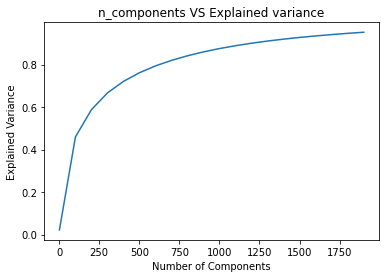

In [19]:
k = np.arange(1,2000,100)

variance =[]
for i in k:
    svd = TruncatedSVD(n_components=i)
    svd.fit_transform(tfidf_data)
    score = svd.explained_variance_ratio_.sum()
    variance.append(score)
    
plt.plot(k, variance)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('n_components VS Explained variance')
plt.show()

In [6]:
svd = TruncatedSVD(n_components=1200)
reduced_tfidf = svd.fit_transform(tfidf_data.toarray())

# Applying K-means Clustering

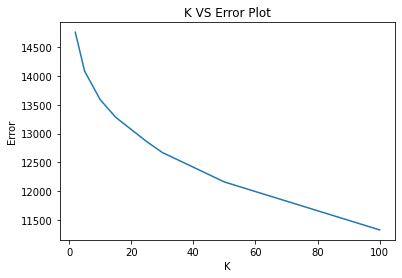

In [23]:
errors = []
k = [2, 5, 10, 15, 25, 30, 50, 100]

for i in k:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(tfidf_data)
    errors.append(kmeans.inertia_)
    
plt.plot(k, errors)
plt.xlabel('K')
plt.ylabel('Error')
plt.title('K VS Error Plot')
plt.show()

In [11]:
kmeans = KMeans(n_clusters=30, random_state=0)
clusters = kmeans.fit_predict(reduced_tfidf)

In [35]:
df['clusters'] = clusters

In [36]:
#dfs = [x for _, x in df.groupby('clusters')]

In [28]:
#kmeans = KMeans(n_clusters=30, random_state=0)
#clusters = kmeans.fit_predict(tfidf_data)

In [13]:
# Plot the clusters
#plt.figure(figsize=(10, 6))
#plt.scatter(reduced_tfidf[:, 0], reduced_tfidf[:, 1], c=clusters, cmap='rainbow')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='X', label='Centroids')
#plt.xlabel('svd Component 1')
#plt.ylabel('svd Component 2')
#plt.title('Clusters of Customer Complaints')
#plt.legend()
#plt.grid(True)
#plt.show()

In [29]:
# Extract the most frequent keywords from a given text

def extract_keywords(text, num_keywords=5):
    words = [word for word in re.findall(r'\w+', text.lower()) if len(word) > 2 and word.isalpha()]
    word_freq = Counter(words)
    return [word for word, freq in word_freq.most_common(num_keywords)]
 

    
    
cluster_texts = df.groupby(clusters)['Tags'].apply(' '.join)
cluster_keywords = cluster_texts.apply(extract_keywords)
 
cluster_keywords

0            [wede, emot, love, bride, beauti]
1           [emot, sky, natur, beauti, sunset]
2       [emot, music, color, expres, portrait]
3       [natur, emot, beauti, light, portrait]
4        [emot, portrait, girl, beauti, white]
5            [love, emot, beauti, girl, coupl]
6      [emot, expres, portrait, beauti, woman]
7     [white, portrait, black, monochrom, old]
8       [beauti, emot, sensual, atract, delic]
9     [emot, portrait, sensual, woman, beauti]
10             [nude, beauti, art, emot, girl]
11         [art, emot, fine, portrait, beauti]
12         [nude, emot, sensual, beauti, girl]
13    [help, measur, white, background, equip]
14           [emot, beauti, girl, smile, hapi]
15     [emot, beauti, peopl, portrait, expres]
16     [emot, stret, citi, photographi, black]
17          [self, emot, portrait, face, girl]
18     [emot, beauti, style, expres, portrait]
19           [emot, beauti, expres, art, fine]
20              [emot, low, key, black, white]
21       [emo

In [34]:
# Get the top terms for a given cluster by summing the TF-IDF scores

def get_top_terms_by_summing_tfidf(cluster_id, matrix, vectorizer, n_terms=5):
    cluster_matrix = matrix[clusters == cluster_id]
    summed_tfidf = cluster_matrix.sum(axis=0)
    summed_tfidf = summed_tfidf.A1
    top_term_indices = summed_tfidf.argsort()[-n_terms:][::-1]
    top_terms = [vectorizer.get_feature_names()[index] for index in top_term_indices]
    return top_terms
 
cluster_top_terms_by_sum = {cluster_id: get_top_terms_by_summing_tfidf(cluster_id, tfidf_data, tfidf) for cluster_id in range(30)}
 
cluster_top_terms_by_sum

{0: ['wede', 'bride', 'love', 'grom', 'coupl'],
 1: ['sky', 'sunset', 'landscap', 'sea', 'emot'],
 2: ['music', 'color', 'ilustr', 'concert', 'emot'],
 3: ['natur', 'light', 'beauti', 'model', 'emot'],
 4: ['emot', 'portrait', 'girl', 'dark', 'beauti'],
 5: ['love', 'coupl', 'romanc', 'romant', 'emot'],
 6: ['expres', 'emot', 'portrait', 'dark', 'fashion'],
 7: ['turkey', 'rain', 'old', 'citi', 'travel'],
 8: ['delic', 'beauti', 'sensual', 'gorgeous', 'atract'],
 9: ['portrait', 'emot', 'sensual', 'woman', 'beauti'],
 10: ['nu', 'nude', 'art', 'nake', 'beauti'],
 11: ['art', 'fine', 'emot', 'portrait', 'beauti'],
 12: ['nude', 'sensual', 'nake', 'sexi', 'bodi'],
 13: ['measur', 'screw', 'tol', 'help', 'safeti'],
 14: ['smile', 'hapi', 'child', 'cute', 'joy'],
 15: ['peopl', 'editori', 'vintag', 'expres', 'beauti'],
 16: ['stret', 'citi', 'urban', 'photographi', 'emot'],
 17: ['self', 'portrait', 'facel', 'face', 'emot'],
 18: ['style', 'fuji', 'vintag', 'beauti', 'editori'],
 19: ['mag

# Applying DBscan Clustering

In [85]:
dbscan = DBSCAN(eps=0.30, min_samples=15)
dbscan.fit(reduced_tfidf)

cluster_labels = dbscan.labels_

In [54]:
#dbscan = DBSCAN(eps=1.0, min_samples=5)
#dbscan.fit(tfidf_data)

#cluster_labels = dbscan.labels_

In [87]:
df['cluster_labels']=cluster_labels

In [88]:
cluster_texts = df.groupby(cluster_labels)['Tags'].apply(' '.join)
cluster_keywords = cluster_texts.apply(extract_keywords)
 
cluster_keywords

-1            [emot, beauti, portrait, girl, white]
 0               [love, beauti, natur, vital, dres]
 1             [beauti, portrait, girl, art, woman]
 2                         [portrait, emot, expres]
 3                  [dive, sea, fish, beauti, emot]
 4     [beauti, sensual, mysteri, stroboscop, imag]
 5                                 [portrait, emot]
 6     [natur, smile, background, portrait, beauti]
 7             [window, eleg, ilumin, loke, voyeur]
 8            [beauti, natur, white, healthi, cute]
 9            [beauti, cute, portrait, love, preti]
 10          [smile, screw, white, background, wod]
 11        [white, portrait, black, monochrom, old]
 12      [beauti, perform, pose, white, background]
 13                 [nude, art, studio, girl, emot]
 14          [beauti, style, emot, portrait, young]
 15             [art, beauti, girl, portrait, bodi]
 16            [art, beauti, portrait, femal, girl]
 17        [beauti, emot, portrait, bodi, gorgeous]
 18         

In [89]:
cluster_top_terms_by_sum = {cluster_id: get_top_terms_by_summing_tfidf(cluster_id, tfidf_data, tfidf) for cluster_id in range(len(set(cluster_labels)))}
 
cluster_top_terms_by_sum

{0: ['wede', 'bride', 'love', 'grom', 'coupl'],
 1: ['sky', 'sunset', 'landscap', 'sea', 'emot'],
 2: ['music', 'color', 'ilustr', 'concert', 'emot'],
 3: ['natur', 'light', 'beauti', 'model', 'emot'],
 4: ['emot', 'portrait', 'girl', 'dark', 'beauti'],
 5: ['love', 'coupl', 'romanc', 'romant', 'emot'],
 6: ['expres', 'emot', 'portrait', 'dark', 'fashion'],
 7: ['turkey', 'rain', 'old', 'citi', 'travel'],
 8: ['delic', 'beauti', 'sensual', 'gorgeous', 'atract'],
 9: ['portrait', 'emot', 'sensual', 'woman', 'beauti'],
 10: ['nu', 'nude', 'art', 'nake', 'beauti'],
 11: ['art', 'fine', 'emot', 'portrait', 'beauti'],
 12: ['nude', 'sensual', 'nake', 'sexi', 'bodi'],
 13: ['measur', 'screw', 'tol', 'help', 'safeti'],
 14: ['smile', 'hapi', 'child', 'cute', 'joy'],
 15: ['peopl', 'editori', 'vintag', 'expres', 'beauti'],
 16: ['stret', 'citi', 'urban', 'photographi', 'emot'],
 17: ['self', 'portrait', 'facel', 'face', 'emot'],
 18: ['style', 'fuji', 'vintag', 'beauti', 'editori'],
 19: ['mag